In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load your dataset (replace with your file path or upload method)
df = pd.read_csv('/content/Sentiment_Analysis_for_Mental_Health.csv')

# Preprocess the data
df = df.dropna(subset=['statement'])  # Remove rows with missing statements
df['statement'] = df['statement'].str.lower()  # Convert text to lowercase

# Assign sentiment labels using VADER
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['statement'].apply(lambda x: get_sentiment(sid.polarity_scores(x)['compound']))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



### Sentiment Distribution
sentiment
negative    28927
positive    17226
neutral      6528
Name: count, dtype: int64


<ipython-input-2-b65624060e40>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


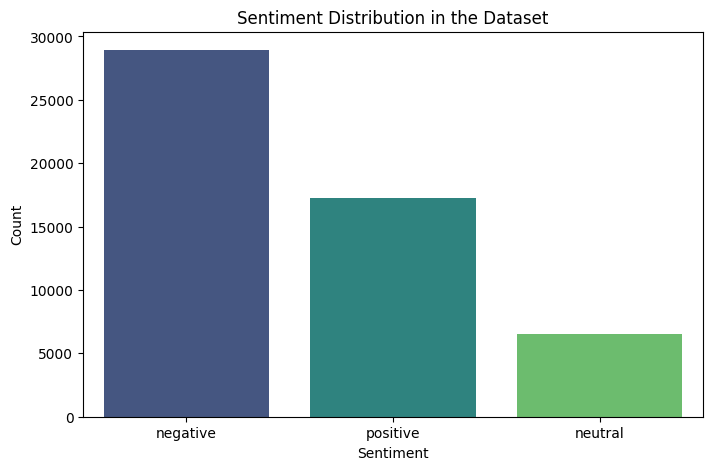

In [2]:
# Calculate sentiment distribution
print("\n### Sentiment Distribution")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [3]:
# Split data into features (X) and labels (y)
X = df['statement']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Make predictions
y_pred = model.predict(X_test_vec)

In [4]:
print("\n### Model Performance Evaluation")
print("\n#### Classification Report")
print(classification_report(y_test, y_pred))


### Model Performance Evaluation

#### Classification Report
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      5819
     neutral       0.75      0.83      0.79      1326
    positive       0.78      0.69      0.73      3392

    accuracy                           0.81     10537
   macro avg       0.79      0.80      0.79     10537
weighted avg       0.81      0.81      0.81     10537




#### Confusion Matrix


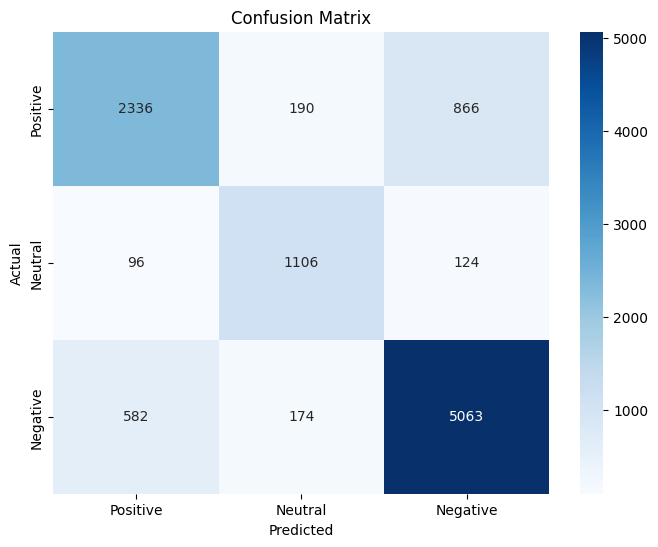

In [5]:
print("\n#### Confusion Matrix")
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Neutral', 'Negative'],
            yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [6]:
print("\n### Top Features for Each Sentiment Class")
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_
classes = model.classes_

for i, sentiment in enumerate(classes):
    top_features = np.argsort(coefficients[i])[-5:]  # Top 5 features
    print(f"\n#### {sentiment.capitalize()}")
    for idx in top_features:
        print(f" - {feature_names[idx]} (coefficient: {coefficients[i][idx]:.4f})")



### Top Features for Each Sentiment Class

#### Negative
 - suicide (coefficient: 4.3471)
 - kill (coefficient: 4.3894)
 - hate (coefficient: 4.4520)
 - bad (coefficient: 4.7940)
 - depression (coefficient: 5.9611)

#### Neutral
 - takes (coefficient: 0.6171)
 - close (coefficient: 0.6638)
 - matter (coefficient: 0.7430)
 - passed (coefficient: 0.8880)
 - far (coefficient: 0.9196)

#### Positive
 - happy (coefficient: 4.2478)
 - great (coefficient: 4.5480)
 - best (coefficient: 4.6767)
 - like (coefficient: 5.6105)
 - love (coefficient: 5.8749)


In [7]:
# Function to predict sentiment
def predict_sentiment(message):
    message = message.lower()
    message_vec = vectorizer.transform([message])
    return model.predict(message_vec)[0]

# Function for detailed wellness suggestions
def provide_detailed_suggestion(sentiment):
    if sentiment == 'positive':
        return (
            "Great to hear you're doing well! A positive mindset is fantastic for your mental health. "
            "To keep this energy going, consider activities like taking a relaxing walk, reading an inspiring book, "
            "or spending time with loved ones. These can reinforce your positivity and help you recharge."
        )
    elif sentiment == 'neutral':
        return (
            "Things seem steady, which is a solid place to be. To add a bit of spark, try a short activity like a 10-minute walk, "
            "listening to your favorite song, or doing something creative like drawing. Small steps like these can gently lift your mood."
        )
    elif sentiment == 'negative':
        return (
            "It sounds like you’re going through a rough patch, and that’s completely okay—it happens to everyone. "
            "Try taking a few deep breaths, talking to a friend, or writing down your thoughts to process them. "
            "If this feeling lingers, consider reaching out to a mental health professional for extra support."
        )
    else:
        return "I’m not sure about that sentiment. How can I assist you further?"

# Test with an example
new_message = "I'm feeling really stressed today."
predicted_sentiment = predict_sentiment(new_message)
print(f"\n### Example Prediction")
print(f"Message: '{new_message}'")
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Wellness Suggestion: {provide_detailed_suggestion(predicted_sentiment)}")


### Example Prediction
Message: 'I'm feeling really stressed today.'
Predicted Sentiment: negative
Wellness Suggestion: It sounds like you’re going through a rough patch, and that’s completely okay—it happens to everyone. Try taking a few deep breaths, talking to a friend, or writing down your thoughts to process them. If this feeling lingers, consider reaching out to a mental health professional for extra support.


In [8]:
import joblib

# Save the trained model and vectorizer
joblib.dump(model, 'sentiment_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [9]:
!pip install fastapi uvicorn nest_asyncio pyngrok joblib

In [10]:
pip install fastapi uvicorn nest_asyncio pyngrok joblib requests

In [11]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import uvicorn
import nest_asyncio
import threading
import time
import socket
import requests
from pyngrok import ngrok

# Apply nest_asyncio to allow Uvicorn in Colab's event loop (if running in Colab)
nest_asyncio.apply()

# Initialize FastAPI app
app = FastAPI()

# Load the saved model and vectorizer
model = joblib.load('sentiment_model.joblib')
vectorizer = joblib.load('tfidf_vectorizer.joblib')

# Define the input data model
class Message(BaseModel):
    text: str

# Define the prediction endpoint
@app.post("/predict")
def predict_sentiment(message: Message):
    text = message.text.lower()
    text_vec = vectorizer.transform([text])
    prediction = model.predict(text_vec)[0]
    suggestion = provide_detailed_suggestion(prediction)
    return {"sentiment": prediction, "suggestion": suggestion}

# Function for wellness suggestions (copied from your notebook)
def provide_detailed_suggestion(sentiment):
    if sentiment == 'positive':
        return (
            "Great to hear you're doing well! A positive mindset is fantastic for your mental health. "
            "To keep this energy going, consider activities like taking a relaxing walk, reading an inspiring book, "
            "or spending time with loved ones. These can reinforce your positivity and help you recharge."
        )
    elif sentiment == 'neutral':
        return (
            "Things seem steady, which is a solid place to be. To add a bit of spark, try a short activity like a 10-minute walk, "
            "listening to your favorite song, or doing something creative like drawing. Small steps like these can gently lift your mood."
        )
    elif sentiment == 'negative':
        return (
            "It sounds like you’re going through a rough patch, and that’s completely okay—it happens to everyone. "
            "Try taking a few deep breaths, talking to a friend, or writing down your thoughts to process them. "
            "If this feeling lingers, consider reaching out to a mental health professional for extra support."
        )
    else:
        return "I’m not sure about that sentiment. How can I assist you further?"

# Define the server function
def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Function to check if a port is in use
def is_port_in_use(port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(('localhost', port)) == 0

# Start the server and expose it with ngrok
if not is_port_in_use(8000):
    # Start the server in a background thread
    thread = threading.Thread(target=run_server)
    thread.start()
    time.sleep(2)  # Wait for the server to start
    print("Server started in the background.")

    # Set up ngrok tunnel
    ngrok.set_auth_token("2u5N9SW1LKvS0qd1g7z5NwZdGA8_7q3NxbzCcETndREdJQyre")  # Replace with your ngrok auth token
    public_url = ngrok.connect(8000)
    print(f"Public URL: {public_url.public_url}")

    # Test the public URL
    response = requests.post(f"{public_url.public_url}/predict", json={"text": "I'm feeling really stressed today."})
    print(response.json())
else:
    print("Server already running on port 8000.")

INFO:     Started server process [23975]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Server started in the background.
Public URL: https://663d-34-106-198-63.ngrok-free.app
INFO:     34.106.198.63:0 - "POST /predict HTTP/1.1" 200 OK
{'sentiment': 'negative', 'suggestion': 'It sounds like you’re going through a rough patch, and that’s completely okay—it happens to everyone. Try taking a few deep breaths, talking to a friend, or writing down your thoughts to process them. If this feeling lingers, consider reaching out to a mental health professional for extra support.'}
